# **Heart disease prediction model training**

In [80]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

## Loading the Data

In [81]:
df = pd.read_csv("/content/heart_2020_cleaned.csv")
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7,0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6,Yes,No,No
319791,No,29.84,Yes,No,No,0,0,No,Male,35-39,Hispanic,No,Yes,Very good,5,Yes,No,No
319792,No,24.24,No,No,No,0,0,No,Female,45-49,Hispanic,No,Yes,Good,6,No,No,No
319793,No,32.81,No,No,No,0,0,No,Female,25-29,Hispanic,No,No,Good,12,No,No,No


## Making a row signrature
Since there is a lot of duplication, we don't want data leakage in the form of test and train overlap.

In [82]:
df['row_signature'] = df.astype(str).agg('-'.join, axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,row_signature
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes,No-16.6-Yes-No-No-3-30-No-Female-55-59-White-Y...
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No,No-20.34-No-No-Yes-0-0-No-Female-80 or older-W...
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No,No-26.58-Yes-No-No-20-30-No-Male-65-69-White-Y...
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes,No-24.21-No-No-No-0-0-No-Female-75-79-White-No...
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No,No-23.71-No-No-No-28-0-Yes-Female-40-44-White-...


## Balancing the data
The data is highly imblanced, we have to downsample it to make it balanced.

In [ ]:
from sklearn.utils import resample

df_min = df.loc[df['HeartDisease'] == 'Yes']
df_max = df.loc[df['HeartDisease'] == 'No']

df_max_downsampled = resample(df_max, replace=False, n_samples=len(df_min), random_state=42)

df_balanced = pd.concat([df_max_downsampled, df_min]).reset_index(drop=True)
df_balanced['HeartDisease'].value_counts()

,count
HeartDisease,
No,27373
Yes,27373


## Making `X` (independent features) and `y` (dependent feature)

In [84]:
X = df_balanced[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'row_signature']]
y = df_balanced['HeartDisease']
X, y

(         BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  MentalHealth  \
 0      25.02      No              No     No               0             7   
 1      23.30      No              No     No               0             0   
 2      25.77     Yes              No     No               0             0   
 3      25.61     Yes             Yes    Yes               2            30   
 4      31.16     Yes              No     No               0             0   
 ...      ...     ...             ...    ...             ...           ...   
 54741  38.45      No              No    Yes              30            15   
 54742  36.21     Yes              No     No               0             0   
 54743  37.12     Yes              No     No               0             0   
 54744  33.20     Yes              No     No               0             0   
 54745  27.41     Yes              No     No               7             0   
 
       DiffWalking     Sex AgeCategory      Race Diabetic Phys

## spliting the test and train data
We are using `GroupShuffleSplit` to avoid overlap of test and train data

In [85]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df_balanced['row_signature']))

In [86]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [87]:
X_test, X_train = X_test.drop(columns=['row_signature']), X_train.drop(columns=['row_signature'])

## Making the pipeline

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline(
    steps=[
        ("scale", StandardScaler())
    ]
)

cat_one_hot_pipe = Pipeline(
    steps=[
        ("oneHot", OneHotEncoder())
    ]
)

In [89]:
df_balanced.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'row_signature'],
      dtype='object')

In [90]:
cat_col = []
num_col = []
target = "HeartDisease"

for col in X_train.columns:
    if(col == target):
        continue    # this is target variable
    if(df[col].dtype == 'object'):
        cat_col.append(col)
    else:
        num_col.append(col)


## Making the column transformer
A pipeline that will **scale** the numeric data and **encode** the categorical data

In [93]:
preprocessor = ColumnTransformer([
    ("Numerical", num_pipe, num_col),
    ("Categorical", cat_one_hot_pipe, cat_col)
])

preprocessor

ColumnTransformer(transformers=[('Numerical',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['BMI', 'PhysicalHealth', 'MentalHealth',
                                  'SleepTime']),
                                ('Categorical',
                                 Pipeline(steps=[('oneHot', OneHotEncoder())]),
                                 ['Smoking', 'AlcoholDrinking', 'Stroke',
                                  'DiffWalking', 'Sex', 'AgeCategory', 'Race',
                                  'Diabetic', 'PhysicalActivity', 'GenHealth',
                                  'Asthma', 'KidneyDisease', 'SkinCancer'])])

## Encoding the target variable

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Update y_train and y_test variables
y_train = y_train_encoded
y_test = y_test_encoded

print("Transformed y_train value counts:")
import pandas as pd
print(pd.Series(y_train).value_counts())

print("\nTransformed y_test value counts:")
print(pd.Series(y_test).value_counts())

print(f"\nOriginal classes: {le.classes_}")
print(f"Mapping: {le.classes_[0]} -> 0, {le.classes_[1]} -> 1")

Transformed y_train value counts:
0    21900
1    21900
Name: count, dtype: int64

Transformed y_test value counts:
0    5473
1    5473
Name: count, dtype: int64

Original classes: ['No' 'Yes']
Mapping: No -> 0, Yes -> 1


## Trying different algorithms
Also trying each with different combinations of parameters

In [101]:
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb

models_list = {
    "K-Nearest Neighbor": {
        "model": KNeighborsClassifier(),
        "params": {
            "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 15, 25],
            "kneighborsclassifier__weights": ["uniform", "distance"],
            "kneighborsclassifier__metric": ["euclidean", "manhattan", "minkowski"],
            "kneighborsclassifier__p": [1, 2]   # p=1 → manhattan, p=2 → euclidean
        }
    },

    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'randomforestclassifier__n_estimators': [5, 10, 20, 30, 50, 100],
            'randomforestclassifier__max_depth': [2, 5, 7, None],
            'randomforestclassifier__max_samples': [0.5, 0.6, 0.75, 0.9, 1]
        }
    },

    "Adaoost": {
        "model": AdaBoostClassifier(estimator=DecisionTreeClassifier()),
        "params": {
            "adaboostclassifier__n_estimators": [10, 20, 25, 30],
            "adaboostclassifier__learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5],
            "adaboostclassifier__estimator__max_depth": [1, 2, 3],
            "adaboostclassifier__estimator__min_samples_split": [2, 5, 10]
        }
    },

    "LightGBM": {
        "model": lgb.LGBMClassifier(),
        "params": {
            "lgbmclassifier__n_estimators": [50, 100, 200],
            "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1],
            "lgbmclassifier__num_leaves": [15, 31, 63],
            "lgbmclassifier__max_depth": [-1, 5, 10],
            "lgbmclassifier__subsample": [0.6, 0.8, 1.0],
            "lgbmclassifier__colsample_bytree": [0.6, 0.8, 1.0]
        }
    },

    "XGBoost": {
        "model": xgb.XGBClassifier(),
        "params": {
            "xgbclassifier__n_estimators": [50, 100, 200],
            "xgbclassifier__learning_rate": [0.01, 0.05, 0.1],
            "xgbclassifier__max_depth": [3, 5, 7],
            "xgbclassifier__subsample": [0.6, 0.8, 1.0],
            "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0]
        }
    }
}

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

recall_yes = make_scorer(
    recall_score,
    pos_label=1
)

for model_name, config in models_list.items():
    model = config["model"]
    params = config["params"]

    pipe = make_pipeline(preprocessor, model)

    ran_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        scoring=recall_yes,
        cv=2,
        verbose=2,
        n_jobs=-1
    )

    ran_search.fit(X_train, y_train)

    print(f"{model_name}:")
    print(f"Best Score: {ran_search.best_score_}")
    print(f"Best parameters: {ran_search.best_params_}")
    print("------------------\n")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
K-Nearest Neighbor:
Best Score: 0.7647031963470319
Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 1, 'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__metric': 'minkowski'}
------------------

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Random Forest:
Best Score: 1.0
Best parameters: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_samples': 1, 'randomforestclassifier__max_depth': 7}
------------------

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Adaoost:
Best Score: 0.7772602739726027
Best parameters: {'adaboostclassifier__n_estimators': 30, 'adaboostclassifier__learning_rate': 0.3, 'adaboostclassifier__estimator__min_samples_split': 5, 'adaboostclassifier__estimator__max_depth': 2}
------------------

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 21900, numbe


`Randomforest` shows 100% recall with a set of parameters but that seems overftting so we have to check the same with the test data.

In [103]:
pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=50, max_samples=1, max_depth=7))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_samples=1,
                                        n_estimators=50))])

In [104]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_samples=1,
                                        n_estimators=50))])

In [107]:
y_pred = pipe.predict(X_test)

In [108]:
print(accuracy_score(y_pred=y_pred, y_true=y_test))
print(confusion_matrix(y_pred=y_pred, y_true=y_test))
print(classification_report(y_pred=y_pred, y_true=y_test))
print(recall_score(y_pred=y_pred, y_true=y_test, pos_label=1))

0.5
[[5473    0]
 [5473    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5473
           1       0.00      0.00      0.00      5473

    accuracy                           0.50     10946
   macro avg       0.25      0.50      0.33     10946
weighted avg       0.25      0.50      0.33     10946

0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model performs pathetic with the test data so it's a clear case of overfitting.

Trying `LightGBM` with the best parameters seems right thing to do as it is the model with second best recall.

In [109]:
pipe = make_pipeline(preprocessor, lgb.LGBMClassifier(subsample= 1.0, num_leaves=15, n_estimators=200, max_depth=-1, learning_rate=0.01, colsample_bytree=1.0))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.01, n_estimators=200,
                                num_leaves=15))])

In [114]:
pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 21900, number of negative: 21900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 43800, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.01, n_estimators=200,
                                num_leaves=15))])

In [115]:
y_pred = pipe.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [116]:
print(accuracy_score(y_pred=y_pred, y_true=y_test))
print(confusion_matrix(y_pred=y_pred, y_true=y_test))
print(classification_report(y_pred=y_pred, y_true=y_test))
print(recall_score(y_pred=y_pred, y_true=y_test, pos_label=1))

0.7583592179791705
[[3850 1623]
 [1022 4451]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5473
           1       0.73      0.81      0.77      5473

    accuracy                           0.76     10946
   macro avg       0.76      0.76      0.76     10946
weighted avg       0.76      0.76      0.76     10946

0.8132651196784213


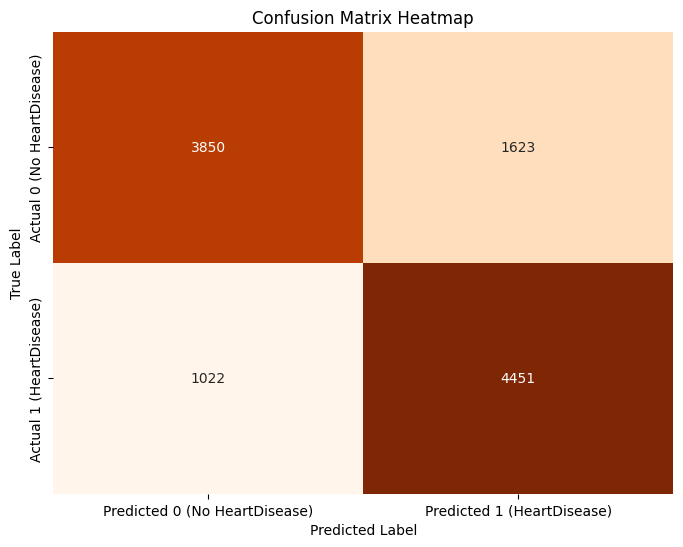

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_pred=y_pred, y_true=y_test), annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Predicted 0 (No HeartDisease)', 'Predicted 1 (HeartDisease)'],
            yticklabels=['Actual 0 (No HeartDisease)', 'Actual 1 (HeartDisease)'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## The model has **81%** recall with the test data
though it also has 75% accuracy rate but the confusion matrix seems good and considering the previous attempts, this is the far best score we can achieve with this data.

## Picking the the model

In [117]:
import pickle

# Define the filename for the pickle file
filename = 'heart_disease_predictor.pkl'

# Open the file in binary write mode and dump the pipe object
with open(filename, 'wb') as file:
    pickle.dump(pipe, file)

print(f"The 'pipe' object has been successfully pickled and saved as '{filename}'")

The 'pipe' object has been successfully pickled and saved as 'heart_disease_predictor.pkl'
